In [30]:
# import packages
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import matplotlib.patches as mpatches
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.libqsturng import qsturng

In [31]:
sns.set_style("darkgrid")

INIT_COL = sns.color_palette('colorblind')[0]
RESP_COL = sns.color_palette('colorblind')[1]

ID = "0704"
figure_path = "figs" + os.sep + ID + os.sep

if not os.path.exists(figure_path):
    os.makedirs(figure_path)
figure_path = figure_path + "expDetermineProb_"


In [32]:
directory = "../results/results_" + ID + "_determine_prob"
idx = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if not filename.endswith(".csv"):
        continue
    newdata = pd.read_csv(f, index_col = None)
    if (idx == 0):
        data = newdata
    else:
        data = pd.concat([data, newdata], ignore_index = True)
    idx += 1
    
print("Number of observations: " + str(len(data.index)))
print("Number of observations per group: " + str(len(data.index) / 99))

Number of observations: 99000
Number of observations per group: 1000.0


In [33]:
data[(data["init_gain"] < 0) | (data["resp_gain"] < 0)][["init_tom", "resp_tom", "init_gain", "resp_gain"]]

,init_tom,resp_tom,init_gain,resp_gain
4058,2,0,-100,150
34397,0,2,50,-50
40842,0,2,50,-50
43942,2,0,-100,50
73112,0,2,50,-100


In [34]:
keep_columns = ["init_zeroToMProb", "resp_zeroToMProb", "init_tom", "resp_tom", "init_gain", "resp_gain",
                "resp_highestValueParetoOutcome", "init_highestValueParetoOutcome", "init_canLie", "resp_canLie"]

def apply_data_transformation(data):
    df = copy.deepcopy(data[keep_columns])
    df["zeroToMProb"] = df.apply(lambda x: x["init_zeroToMProb"] if (x["init_tom"] == 0) else x["resp_zeroToMProb"], axis=1)
    df["name"] = df.apply(lambda x: "init_resp" if ((x["init_tom"] == 0) and (x["resp_tom"] == 0)) else ("init" if x["init_tom"] == 0 else "resp"), axis=1)
    
    sub_df = df.loc[(df["name"] == "init_resp")]
    new_row = sub_df.iloc[[0]].copy()
    new_row["name"] = "init"
    new_df = new_row
    new_row = sub_df.iloc[[0]].copy()
    new_row["name"] = "resp"
    new_df = pd.concat([new_df, new_row]).reset_index(drop=True)
    
    for idx in range(1, len(sub_df.index)):
        new_row = sub_df.iloc[[idx]].copy()
        new_row["name"] = "init"
        new_df = pd.concat([new_df, new_row]).reset_index(drop=True)
        new_row["name"] = "resp"
        new_df = pd.concat([new_df, new_row]).reset_index(drop=True)
    df = pd.concat([new_df, df]).reset_index(drop=True)

    df = df.loc[df["name"] != "init_resp"]
    df["gain"] = df.apply(lambda x: x["init_gain"] if x["name"] == "init" else x["resp_gain"], axis=1)
    
    return df


In [35]:
df_transformed = apply_data_transformation(data)

In [36]:
print(f'number of observations where score gain is below 0: {len(df_transformed[df_transformed["gain"] < 0])}')

number of observations where score gain is below 0: 0


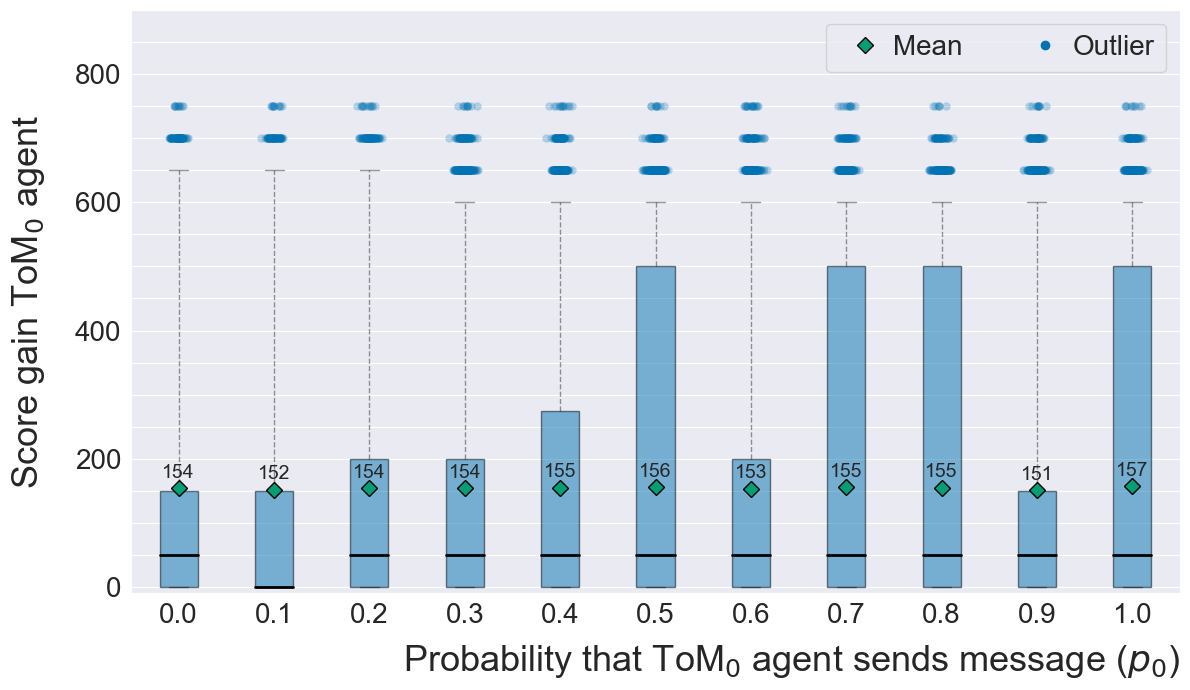

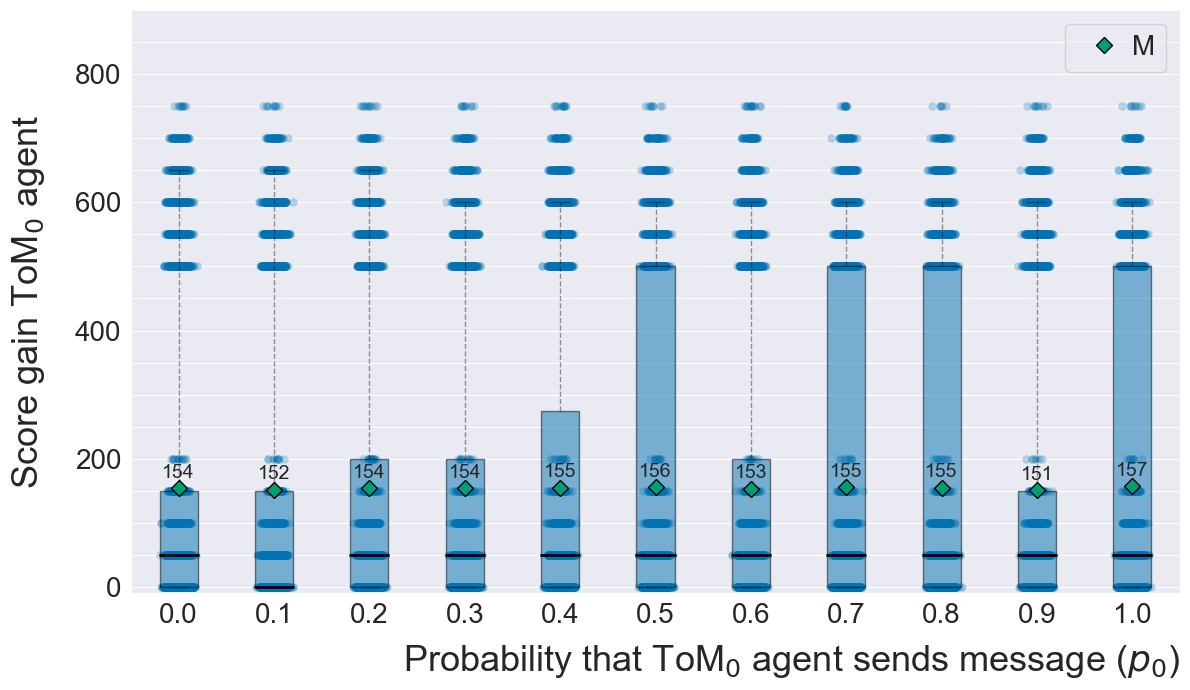

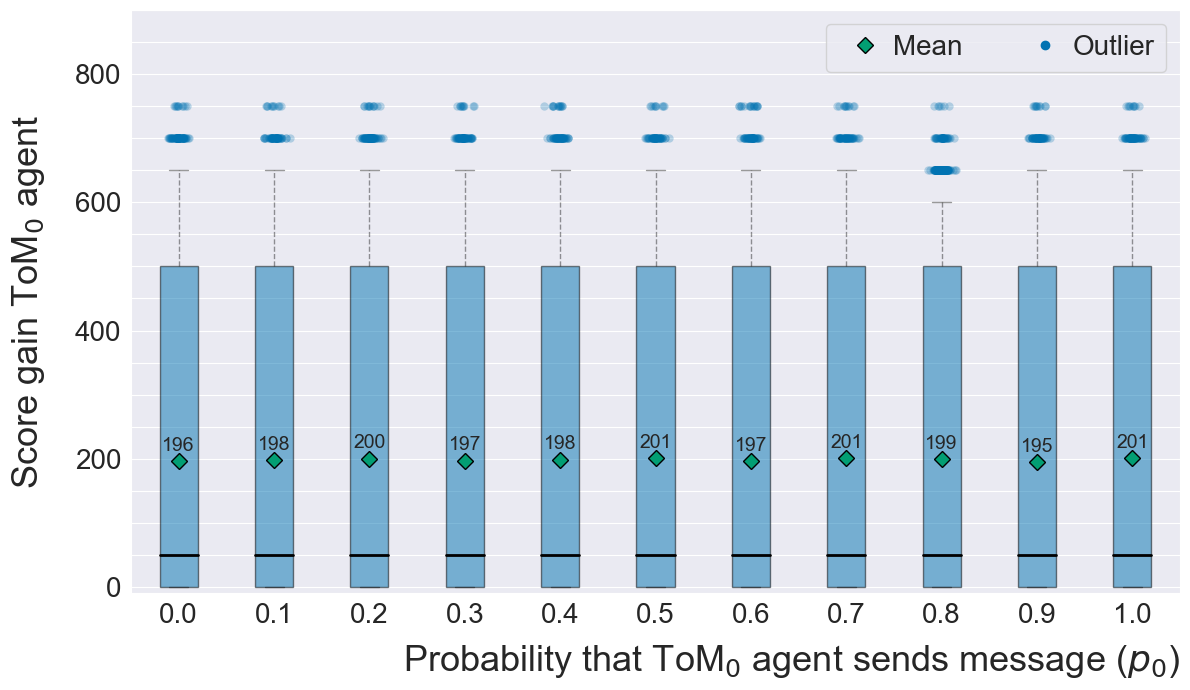

In [37]:
# Figure settings
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor=sns.color_palette('colorblind')[2], markersize=8)
whiskerprops = dict(alpha=0.4, linestyle="dashed")
capprops = dict(alpha=0.4)
medianprops = dict(lw=2, color="black")
boxprops = dict(facecolor=INIT_COL, color="black", alpha=0.5)

BIN_WIDTH = 0.4
TICK_SIZE = 20
VALUE_SIZE = 14
LABEL_SIZE = 26
figsize = (12,7)


def make_box_plot(data, pos, ax, draw_points):
    bp = ax.boxplot(data, patch_artist=True, notch=False, vert=1, showfliers=True, whis=[2.5, 97.5],
                    positions=pos, widths=BIN_WIDTH, showmeans=True, meanprops=meanpointprops,
                    whiskerprops=whiskerprops, medianprops=medianprops, capprops=capprops,
                    boxprops=boxprops)
    
    plt.setp(bp['fliers'][0], color='black', alpha=0)
    
    if draw_points:
        x = np.random.normal(pos[0], 0.05, size=len(data))
        y = data
        ax.scatter(x, y, color=INIT_COL, alpha=0.25, linewidth=0)
    else:
        top_points = bp["fliers"][0].get_data()
        x = np.random.normal(top_points[0], 0.05, size=len(top_points[0]))
        y = top_points[1]
        ax.scatter(x, y, color=INIT_COL, alpha=0.25, linewidth=0)
    
    
def make_plot(data, draw_points):
    fig, ax = plt.subplots(figsize = figsize)
    max_mean = 0

    for i in range(0, 11, 1):
        plot_data = list(data[data["zeroToMProb"] == i/10]["gain"])
        make_box_plot(plot_data, [i], ax, draw_points)
        
        new_val = np.mean(plot_data)
        ax.text(i, new_val+10, round(new_val), size=VALUE_SIZE, ha="center", va='bottom')
        max_mean = np.max([new_val, max_mean])
        # print(f"- p_0={i/10}, mean={new_val}, sd={np.std(plot_data)}")
        
    # Add horizontal line...
    # ax.hlines(y=max_mean, xmin=-BIN_WIDTH, xmax=10 + BIN_WIDTH, linestyles='dashed', label='smt', lw=2, colors=meanpointprops["markerfacecolor"])
        
    # handles, _ = ax.get_legend_handles_labels()
    # ax.yaxis.set_tick_params(pad=1.6*max(T.label1.get_window_extent().width for T in ax.yaxis.majorTicks))
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim(top=900, bottom=-10)
    if draw_points:
        ax.legend([plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
                                markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0)],
                # handles[0]),
                ("Mean"), fontsize=TICK_SIZE, ncol=1, fancybox=True, loc="upper right", handletextpad=0)
    else:
        ax.legend((plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
                                markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0),
                plt.Line2D([0],[0], color=INIT_COL, marker="o", linewidth=0, alpha=1)),
                # handles[0]),
                ("Mean", "Outlier"), fontsize=TICK_SIZE, ncol=2, fancybox=True, loc="upper right", handletextpad=0)
    
    ax.xaxis.grid(False, which ="both")
    ax.yaxis.grid(True, which="both")

    ax.set_ylabel(r"Score gain ToM$_0$ agent", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel(r"Probability that ToM$_0$ agent sends message ($p_0$)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()

make_plot(df_transformed, False)
plt.savefig(figure_path + "boxplot.pdf")

make_plot(df_transformed, True)
plt.savefig(figure_path + "boxplot_with_points.png")

make_plot(df_transformed.loc[(df_transformed["init_highestValueParetoOutcome"] != -1) & (df_transformed["resp_highestValueParetoOutcome"] != -1)],
          False)
plt.savefig(figure_path + "boxplot_pareto.pdf")

In [38]:
data_list = [list(df_transformed[df_transformed["zeroToMProb"] == i/10]["gain"]) for i in range(0, 11,1)]
print(stats.kruskal(*data_list))
print(stats.f_oneway(*data_list))

KruskalResult(statistic=8.99137731444199, pvalue=0.5329220976236391)
F_onewayResult(statistic=0.514630394708275, pvalue=0.8811881527183493)


In [39]:
def output_ranks(data):
    ma = []
    r = stats.rankdata(np.concatenate(data), method='average')
    total = 0

    for i, group in enumerate(data):
        # Compute the rank mean for group i
        g = r[total:total + len(group)]
        print(g)
        gt = len(g)
        rm = np.sum(g) / gt
        total += gt
        ma.append({"Type": f"group_{i+1}", "H": gt, "Middle Rank": rm})

    ma.append({"Type": "total", "H": total, "Middle Rank": ""})
    ma_return = pd.DataFrame.from_dict(ma)
    return ma_return

# Example usage
out = output_ranks(data_list)
print(out.to_string(index=False))

[97370.  65484.5 87771.  ... 65484.5 79478.  87771. ]
[87771.  65484.5 87771.  ... 26716.  26716.  65484.5]
[104567.  104567.   87771.  ...  65484.5  26716.   79478. ]
[ 26716.   26716.   65484.5 ... 104567.   87771.   65484.5]
[65484.5 87771.  97370.  ... 26716.  26716.  65484.5]
[26716. 26716. 87771. ... 26716. 97370. 26716.]
[26716.  26716.  97370.  ... 26716.  26716.  65484.5]
[26716.  26716.  26716.  ... 26716.  65484.5 87771. ]
[ 87771. 104567.  26716. ...  26716.  26716.  87771.]
[26716.  26716.  87771.  ... 65484.5 26716.  65484.5]
[26716.  26716.  26716.  ... 26716.  65484.5 26716. ]
    Type      H  Middle Rank
 group_1  10000   55189.6443
 group_2  10000  54302.47805
 group_3  10000   54945.9862
 group_4  10000   54855.5852
 group_5  10000  55193.88345
 group_6  10000  55074.34655
 group_7  10000   55092.6845
 group_8  10000   55094.2966
 group_9  10000   55164.3871
group_10  10000   54768.9553
group_11  10000  55323.25275
   total 110000             


In [40]:

def calculate_tukey_critical_value(data, alpha):
    """
    Calculate the Tukey critical value for the given data
    using the Tukey's HSD test and qsturng function.

    Arguments:
    data -- a list of lists containing the data points for each group
    alpha -- significance level

    Returns:
    The Tukey critical value.
    """
    num_groups = len(data)
    nobs = [len(group) for group in data]
    k = sum(nobs)
    df_between = num_groups - 1
    df_within = k - num_groups

    q_value = qsturng(1 - alpha, num_groups, df_within)
    print(q_value)
    critical_value = q_value * np.sqrt((2 * df_within) / np.mean(nobs))
    return critical_value

def calculate_pooled_variance(data):
    """
    Calculate the pooled variance across groups given a list of lists of data points.

    Arguments:
    data -- a list of lists containing the data points for each group

    Returns:
    The pooled variance.
    """
    all_data = np.concatenate(data)
    num_groups = len(data)
    nobs = [len(group) for group in data]
    total_samples = sum(nobs)
    grand_mean = np.mean(all_data)

    ss_total = np.sum((all_data - grand_mean) ** 2)
    ss_within = np.sum([(np.sum((group - np.mean(group)) ** 2)) for group in data])

    df_total = total_samples - 1
    df_within = total_samples - num_groups

    pooled_variance = ss_within / df_within
    return pooled_variance



print(calculate_tukey_critical_value(data_list.copy(), 0.05))
result = calculate_pooled_variance(data_list)
data_points_per_group = [len(group) for group in data_list]
print(qsturng(0.95, len(data_list), sum(data_points_per_group)) * np.sqrt(result / np.mean(data_points_per_group)))


4.552051932253097
21.349948545078387
10.61378000453709


{0.0: (154.04, 7.262441980853506), 0.1: (151.63, 7.259571996649868), 0.2: (154.395, 7.307369033737981), 0.3: (153.69, 7.270255553112191), 0.4: (154.54, 7.27640944944492), 0.5: (155.575, 7.293423861879493), 0.6: (153.32, 7.230102184632976), 0.7: (155.25, 7.292474496300003), 0.8: (154.605, 7.250600079499753), 0.9: (151.41, 7.232795464411884), 1.0: (157.24, 7.3232399030074316)}


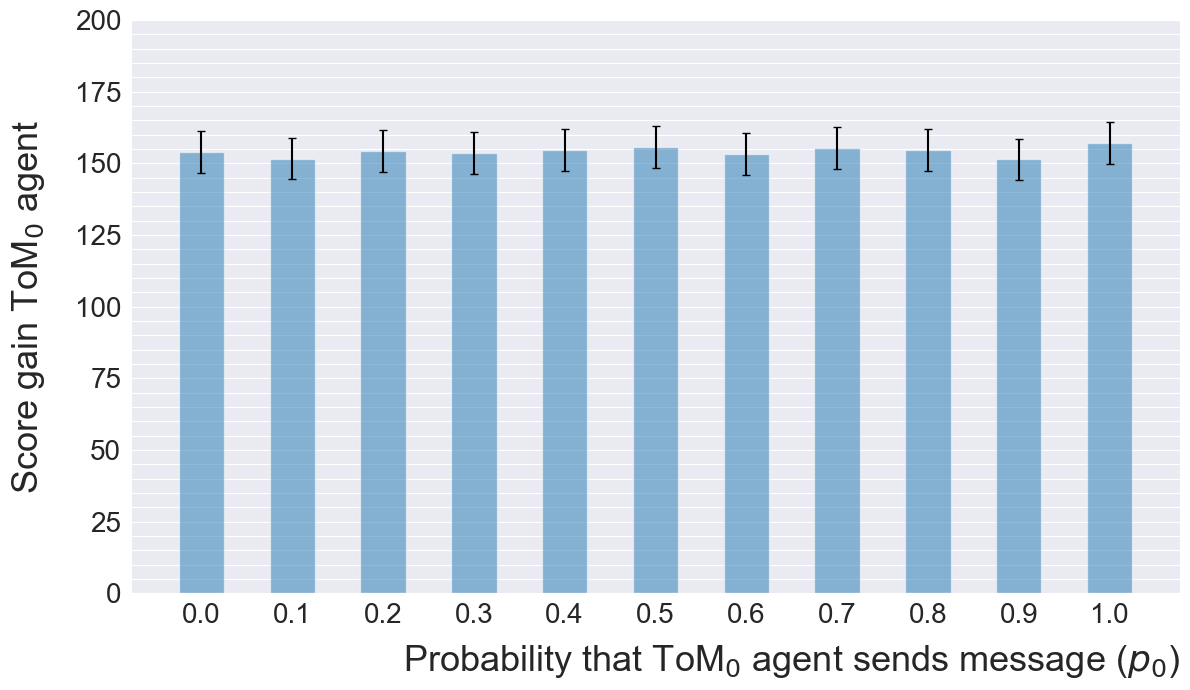

In [41]:
# Figure settings
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor=sns.color_palette('colorblind')[2], markersize=8)
whiskerprops = dict(alpha=0.4, linestyle="dashed")
capprops = dict(alpha=0.4)
medianprops = dict(lw=2, color="black")
boxprops = dict(facecolor=INIT_COL, color="black", alpha=0.5)

BIN_WIDTH = 0.05
TICK_SIZE = 20
VALUE_SIZE = 14
LABEL_SIZE = 26
figsize = (12,7)


def make_bar_plot(data, ax):
    means = [i for i, _ in data.values()]
    errors = [i for _, i in data.values()]
    ax.bar(data.keys(), means, width=BIN_WIDTH, alpha=0.5, yerr=errors, capsize=3)
    
    # if draw_points:
    #     x = np.random.normal(pos[0], 0.05, size=len(data))
    #     y = data
    #     ax.scatter(x, y, color=INIT_COL, alpha=0.25, linewidth=0)
    # else:
    #     top_points = bp["fliers"][0].get_data()
    #     x = np.random.normal(top_points[0], 0.05, size=len(top_points[0]))
    #     y = top_points[1]
    #     ax.scatter(x, y, color=INIT_COL, alpha=0.25, linewidth=0)
    
    
def make_plot(data):
    fig, ax = plt.subplots(figsize = figsize)
    max_mean = 0
    plot_dict = {}
    confidence = 1 - 0.05 / 55
    
    for i in range(0, 11, 1):
        plot_data = list(data[data["zeroToMProb"] == i/10]["gain"])
        t_stat = stats.t.ppf(confidence, len(plot_data) - 1)
        plot_dict[i/10] = (np.mean(plot_data), t_stat * np.std(plot_data) / math.sqrt(len(plot_data)))
        max_mean = max(max_mean, np.mean(plot_data))
        
    print(plot_dict)
    make_bar_plot(plot_dict, ax)
        
    # new_val = np.mean(plot_data)
    # ax.text(i, new_val+10, round(new_val), size=VALUE_SIZE, ha="center", va='bottom')
    # max_mean = np.max([new_val, max_mean])
    # print(f"- p_0={i/10}, mean={new_val}, sd={np.std(plot_data)}")
        
    # Add horizontal line...
    # ax.hlines(y=max_mean, xmin=-BIN_WIDTH, xmax=1 + BIN_WIDTH, linestyles='dashed', label='smt', lw=2, colors=meanpointprops["markerfacecolor"])
        
    # handles, _ = ax.get_legend_handles_labels()
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_ylim(top=200, bottom=0)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    # ax.legend((plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
    #                         markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0),
    #         plt.Line2D([0],[0], color=INIT_COL, marker="o", linewidth=0, alpha=1),
    #         handles[0]),
    #         ("Mean", "Outlier", "  Max mean"), fontsize=TICK_SIZE, ncol=3, fancybox=True, loc="upper right", handletextpad=0)
    
    ax.xaxis.grid(False, which ="both")
    ax.yaxis.grid(True, which="both")

    ax.set_ylabel(r"Score gain ToM$_0$ agent", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel(r"Probability that ToM$_0$ agent sends message ($p_0$)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()
    
make_plot(df_transformed)
plt.savefig(figure_path + "barplot_with_CI.pdf")

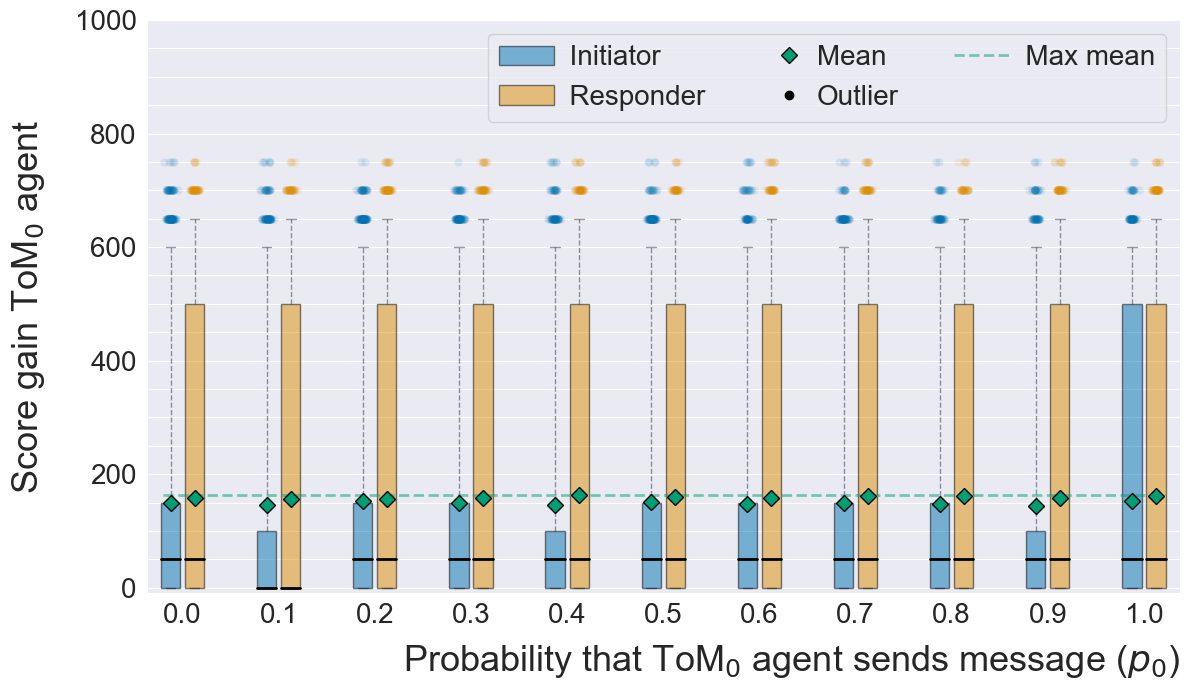

In [43]:
# Figure settings
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor=sns.color_palette('colorblind')[2], markersize=8)
whiskerprops = dict(alpha=0.4, linestyle="dashed")
capprops = dict(alpha=0.4)
medianprops = dict(lw=2, color="black")
boxprops = dict(color="black", alpha=0.5)

BIN_WIDTH = 0.4
TICK_SIZE = 20
LABEL_SIZE = 26
figsize = (12,7)

def make_box_plot_multiple(data, pos, ax):
    bp = ax.boxplot(data, patch_artist=True, notch=False, vert=1, showfliers=True, whis=[2.5, 97.5],
                    positions=pos, widths=BIN_WIDTH, showmeans=True, meanprops=meanpointprops,
                    whiskerprops=whiskerprops, medianprops=medianprops, capprops=capprops,
                    boxprops=boxprops)

    bp['boxes'][0].set(facecolor=INIT_COL)
    bp['boxes'][1].set(facecolor=RESP_COL)
    
    plt.setp(bp['fliers'][0], color='black', alpha=0)
    plt.setp(bp['fliers'][1], color='black', alpha=0)
    
    fill_colors = [INIT_COL, RESP_COL]
    for i in [0,1]:
        top_points = bp["fliers"][i].get_data()
        x = np.random.normal(top_points[0], 0.05, size=len(top_points[0]))
        y = top_points[1]
        ax.scatter(x, y, color=fill_colors[i], alpha=0.1, linewidth=0)

def make_plot_differentiate(data):
    fig, ax = plt.subplots(figsize = figsize)
    max_mean_init = 0
    max_mean_resp = 0

    for i in range(0, 21, 2):
        plot_data = [list(data[(data["zeroToMProb"] == i/20) & (data["name"] == "init")]["gain"]),
                    list(data[(data["zeroToMProb"] == i/20) & (data["name"] == "resp")]["gain"])]
        make_box_plot_multiple(plot_data, [i-0.25, i+0.25], ax)
        
        new_val_init = np.mean(plot_data[0])
        new_val_resp = np.mean(plot_data[1])
        max_mean_init = np.max([new_val_init, max_mean_init])
        max_mean_resp = np.max([new_val_resp, max_mean_resp])
        
    # Add horizontal line...
    ax.hlines(y=np.max([max_mean_init, max_mean_resp]), xmin=-BIN_WIDTH, xmax=20+BIN_WIDTH, linestyles='dashed', label='smt', lw=2, colors=meanpointprops["markerfacecolor"],
              alpha=0.5)
        
    handles, _ = ax.get_legend_handles_labels()
    # ax.yaxis.set_tick_params(pad=1.6*max(T.label1.get_window_extent().width for T in ax.yaxis.majorTicks))
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_xticks(range(0, 21, 2))
    ax.set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim(top=1000, bottom=-10)
    ax.legend((mpatches.Patch(facecolor=INIT_COL, edgecolor='black', label="Initiator", alpha=boxprops["alpha"]),
            mpatches.Patch(facecolor=RESP_COL, edgecolor='black', label="Responder", alpha=boxprops["alpha"]),
            plt.Line2D([0], [0], color=meanpointprops["markerfacecolor"], marker=meanpointprops["marker"], 
                            markeredgecolor=meanpointprops["markeredgecolor"], markersize=meanpointprops["markersize"], linewidth=0),
            plt.Line2D([],[], color="black", marker="o", markeredgecolor="black", linewidth=0), 
            handles[0]),
                ("  Initiator", "  Responder", "Mean", "Outlier", "  Max mean"), fontsize=TICK_SIZE, ncol=3, fancybox=True, loc="upper right",
                handletextpad=0)
    ax.xaxis.grid(False, which ="both")
    ax.yaxis.grid(True, which="both")

    ax.set_ylabel(r"Score gain ToM$_0$ agent", fontsize=LABEL_SIZE, labelpad=20)
    ax.set_xlabel(r"Probability that ToM$_0$ agent sends message ($p_0$)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()

make_plot_differentiate(df_transformed)
plt.savefig(figure_path + "boxplot_separate.pdf")

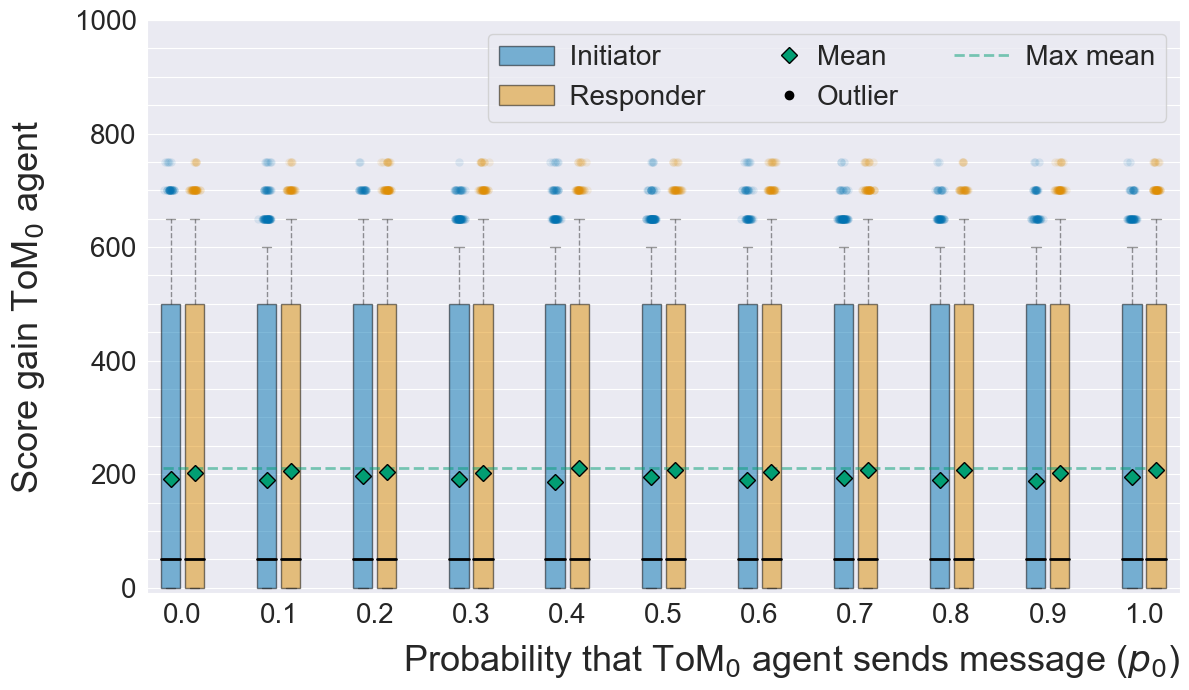

In [44]:
make_plot_differentiate(df_transformed.loc[(df_transformed["init_highestValueParetoOutcome"] != -1) & (df_transformed["resp_highestValueParetoOutcome"] != -1)])
plt.savefig(figure_path + "boxplot_separate_pareto.pdf")

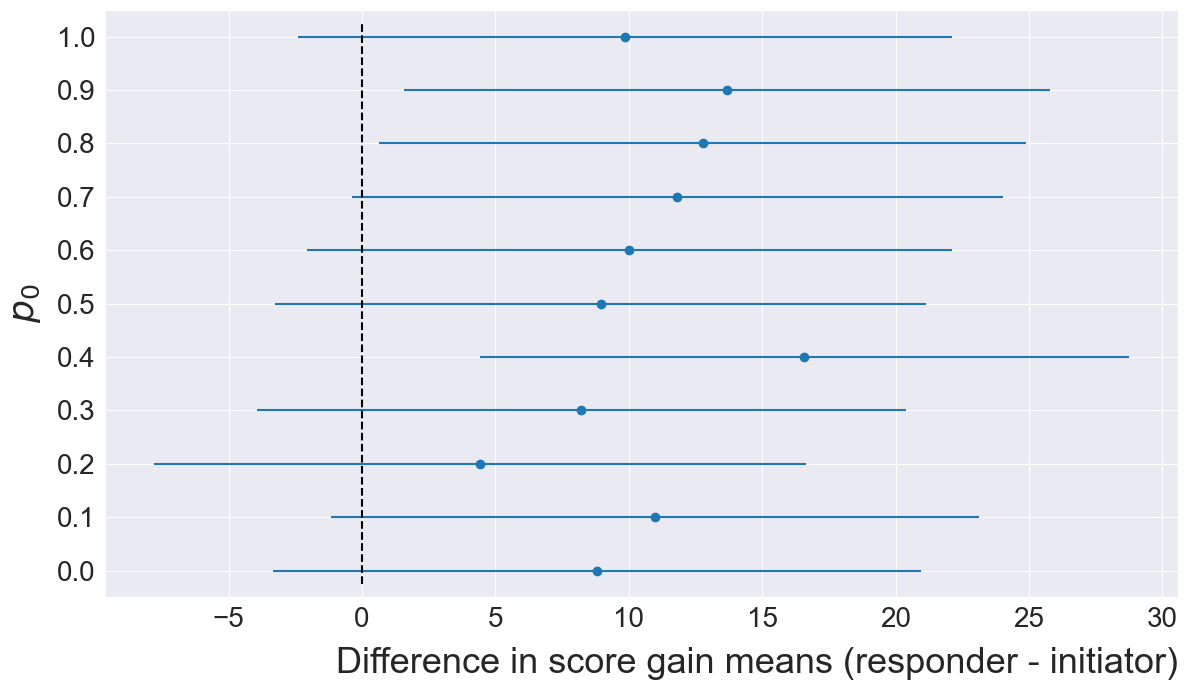

In [47]:
def make_difference_plot():
    # Calculate the means for each group and setting
    means = df_transformed.groupby(['name', 'zeroToMProb'])['gain'].mean().unstack()

    # Calculate the difference in means
    diff_means = means.iloc[1, :] - means.iloc[0, :]

    # Reset the index
    diff_means = diff_means.reset_index()
    diff_means.columns = ["zeroToMProb", "diff_gain"]

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize = figsize)

    errors = []
    confidence = 1 - 0.05 /11
    # confidence = 0.95
    for _, row in diff_means.iterrows():
        stat_data_init = df_transformed[(df_transformed["zeroToMProb"] == row["zeroToMProb"]) & (df_transformed["name"] == "init")]
        n_init = len(stat_data_init)
        stat_data_resp = df_transformed[(df_transformed["zeroToMProb"] == row["zeroToMProb"]) & (df_transformed["name"] == "resp")]
        n_resp = len(stat_data_resp)
        t_stat = stats.t.ppf(confidence, n_init + n_resp - 2)
        pooled_var = ((n_init-1) * (np.std(stat_data_init["gain"])**2) + (n_resp-1) * (np.std(stat_data_resp["gain"])**2)) / (n_init + n_resp - 2)
        errors.append(t_stat * math.sqrt(pooled_var * ((1 / n_init) + (1 / n_resp))))
        
    # plot the difference
    ax.errorbar(diff_means['diff_gain'], diff_means['zeroToMProb'], fmt="o", xerr=errors)
    ax.vlines(0, ymin = -0.025, ymax=1.025, linestyle='dashed', color="black")

    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_ylim((-0.05, 1.05))

    # Set labels
    ax.set_xlabel("Difference in score gain means (responder - initiator)", fontsize=LABEL_SIZE, loc="right", labelpad=10)
    ax.set_ylabel(r"$p_0$", fontsize=LABEL_SIZE,  labelpad=10)
    fig.tight_layout()
    plt.minorticks_on()

make_difference_plot()

plt.savefig(figure_path + "difference_means.pdf")
